In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import DenseNet121 #Densenet121 모델 사용
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) #채널이 무조건 3개여야 하며 크기는 최소 32 이상

x=model_d.output

x= GlobalAveragePooling2D()(x) #전역 평균 풀링 레이어 추가
x= BatchNormalization()(x) #배치 정규화 레이어
x= Dropout(0.5)(x)
#Fully Connected 레이어 추가
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x) #과적합 감소용 드롭아웃 레이어

preds=Dense(6,activation='softmax')(x) #FC-layer. 클래스가 7개이므로 softmax 7개 설정

In [3]:
model=Model(inputs=model_d.input,outputs=preds) 
model.summary() #모델 요약

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [4]:
#Freeze
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) #모델 생성
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [7]:
data=[] #데이터
labels=[] #라벨
random.seed(42)
imagePaths = sorted(list(os.listdir("emotion_FixedVer/"))) #데이터셋 경로
random.shuffle(imagePaths) #셔플
print(imagePaths)
#이미지 읽기 및 라벨링
for img in imagePaths:
    path=sorted(list(os.listdir("emotion_FixedVer/"+img)))
    for i in path:
        image = cv2.imread("emotion_FixedVer/"+img+'/'+i) #이미지 읽기
        image = cv2.resize(image, (128,128)) #이미지 사이즈 편집
        image = img_to_array(image) #이미지 배열화
        data.append(image) #data 배열에 데이터 추가
        l = label = img
        labels.append(l) #labels 배열에 데이터 추가

['neutral', 'fearful', 'happy', 'sad', 'angry', 'surprised']


In [8]:
data = np.array(data, dtype="float32") / 255.0 #데이터 타입 변경 및 numpy 배열화
labels = np.array(labels) #라벨 numpy 배열화
mlb = LabelBinarizer() #데이터 전처리(원핫인코딩)
labels = mlb.fit_transform(labels) #데이터에 대해서 fit 작업과 transform 작업을 적용해주는 것
print(labels[0])

[0 0 0 1 0 0]


In [9]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.3,random_state=42) #train용과 test용으로 데이터셋 분리. test 30%
print(xtrain.shape, xtest.shape)

(19507, 128, 128, 3) (8361, 128, 128, 3)


In [10]:
#검증 손실에 변화가 없는 경우 학습률을 감소시켜 도움을 줌
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3) 
checkpoint = ModelCheckpoint('Densenet121_revised1.h5', verbose=1, save_best_only=True) #체크포인트를 두고 모델 저장

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)


datagen.fit(xtrain)
# 모델 학습
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=500,
               verbose=2,#verbose 2는 '세대 당 한 라인'을 의미
               callbacks=[anne, checkpoint], #학습과 검증 과정에서 적용할 콜백 리스트
               validation_data=(xtrain, ytrain)) #steps_per_epoch일 때 사용하는 것으로 샘플 배치 데이터 수

Epoch 1/500


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[128,7] labels_size=[128,6]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-10-f1979bfd475c>:10) ]] [Op:__inference_train_function_18078]

Function call stack:
train_function


In [22]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 8613 	accurately-predicted-data: 4931 	 wrongly-predicted-data:  3682
Accuracy: 57.251 %


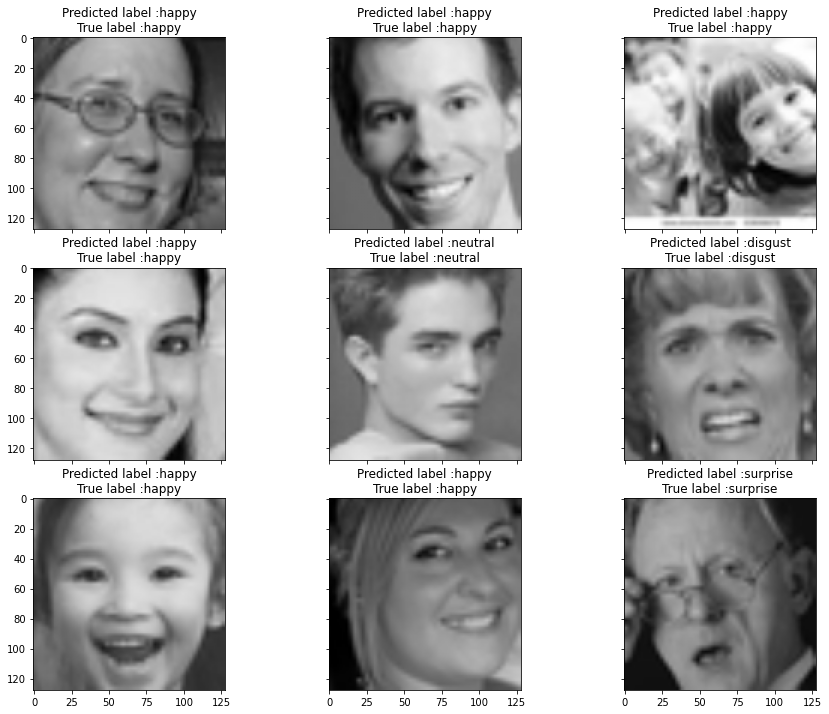

In [17]:
label=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

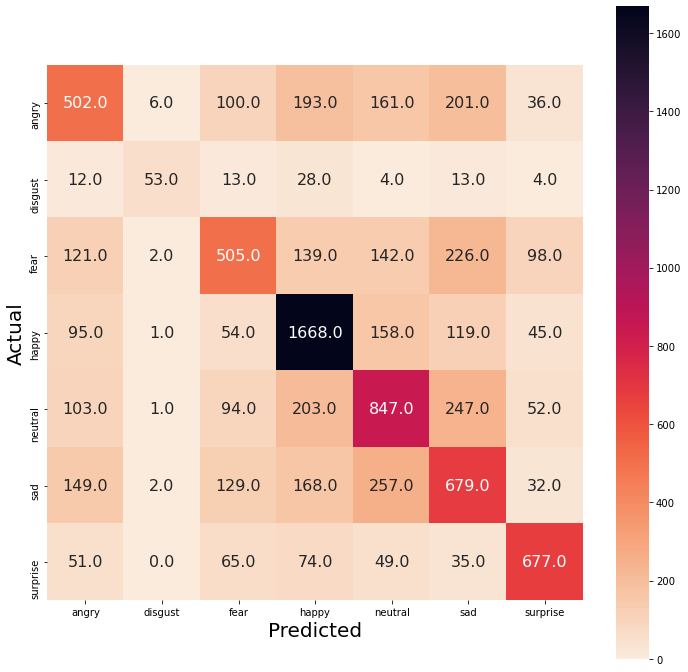

In [18]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)